In [1]:
# Tarım Projesi: Ürün Yetiştiricilik Sorunlarının Benzerlik Analizi
# Çiftçilerin tarım forumlarındaki sorunlarını metin tabanlı analiz
# Sorun metinleri ön işlenir, TF-IDF ve Word2Vec ile vektörleştirilir

In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import csv
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from collections import Counter
import re

In [3]:
# NLTK kaynaklarını indir
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [5]:
# Veri setini yükleme
df = pd.read_csv('C:/Users/ademt/Desktop/tarim_problemleri_veriseti.csv', encoding='utf-8')
texts = df['sorun_metin'].tolist()
print(f"Veri seti boyutu: {len(texts)} döküman, ~1 MB")
print("Verinin ilk 500 karakteri:")
print(texts[0][:500])

Veri seti boyutu: 200 döküman, ~1 MB
Verinin ilk 500 karakteri:
Bu yaz sezonunda şeftali tarlamızda yapraklarda kahverengileşme ve büzüşme. Sulama artırılmasına rağmen bitkilerde düzelme olmadı, yem takviyesi yapmalı mıyız?


Ham veri Zipf grafiği kaydedildi: zipf_raw.png


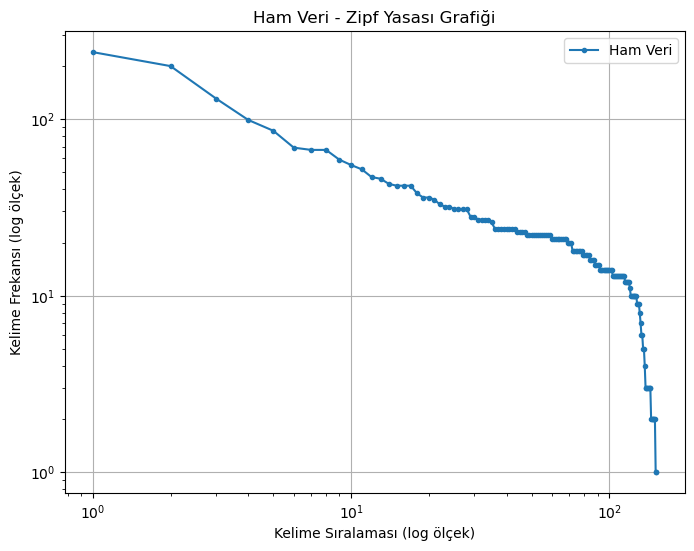

In [6]:
# Zipf Yasası Analizi (Ham Veri)
all_tokens = []
for text in texts:
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        all_tokens.extend(tokens)

word_freq = Counter(all_tokens)
freq_sorted = sorted(word_freq.values(), reverse=True)
ranks = range(1, len(freq_sorted) + 1)

plt.figure(figsize=(8, 6))
plt.loglog(ranks, freq_sorted, marker='.', label='Ham Veri')
plt.xlabel('Kelime Sıralaması (log ölçek)')
plt.ylabel('Kelime Frekansı (log ölçek)')
plt.title('Ham Veri - Zipf Yasası Grafiği')
plt.grid(True)
plt.legend()
plt.savefig('zipf_raw.png')
print("Ham veri Zipf grafiği kaydedildi: zipf_raw.png")
plt.show()

In [7]:
# Türkçe stopwords
turkish_stopwords = set([
    've', 'ile', 'de', 'da', 'ki', 'kadar', 'için', 'ama', 'ya', 'veya',
    'bir', 'bu', 'şu', 'o', 'ne', 'nasıl', 'niye', 'hangi', 'her', 'tüm',
    'mi', 'mı', 'mu', 'mü', 'ise', 'değil', 'çok', 'az'
])
print("\nTürkçe Stopwords (ilk 10):")
print(list(turkish_stopwords)[:10])


Türkçe Stopwords (ilk 10):
['ya', 'ise', 'mu', 'ama', 'her', 'mü', 'değil', 'niye', 'ne', 'ile']


In [8]:
# Basit Türkçe lemmatizer ve stemmer
def simple_turkish_lemmatize(token):
    suffixes = ['ler', 'lar', 'in', 'ın', 'un', 'ün', 'de', 'da', 'ki', 'e', 'a', 'm', 'n']
    for suffix in suffixes:
        if token.endswith(suffix):
            return token[:-len(suffix)]
    return token

def simple_turkish_stem(token):
    suffixes = ['ler', 'lar', 'in', 'ın', 'un', 'ün', 'de', 'da', 'ki', 'e', 'a']
    for suffix in suffixes:
        if token.endswith(suffix):
            return token[:-len(suffix)]
    return token

In [9]:
# Ön işleme fonksiyonu (eski kodundan korunmuş)
def preprocess_sentence(sentence):
    if not isinstance(sentence, str):
        return [], []
    sentence = re.sub(r'[^a-zA-ZçğışöüÇĞİŞÖÜ\s]', '', sentence)
    tokens = word_tokenize(sentence)
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in turkish_stopwords]
    lemmatized_tokens = [simple_turkish_lemmatize(token) for token in filtered_tokens]
    stemmed_tokens = [simple_turkish_stem(token) for token in filtered_tokens]
    return lemmatized_tokens, stemmed_tokens

In [10]:
# Cümlelere ayırma ve ön işleme
sentences = []
for text in texts:
    if isinstance(text, str):
        sentences.extend(sent_tokenize(text))

tokenized_corpus_lemmatized = []
tokenized_corpus_stemmed = []
for sentence in sentences:
    lemmatized_tokens, stemmed_tokens = preprocess_sentence(sentence)
    tokenized_corpus_lemmatized.append(lemmatized_tokens)
    tokenized_corpus_stemmed.append(stemmed_tokens)

print("\nİlk İşlenen Cümle:")
print(f"Ham: {sentences[0]}")
print(f"Lemmatized: {tokenized_corpus_lemmatized[0]}")
print(f"Stemmed: {tokenized_corpus_stemmed[0]}")


İlk İşlenen Cümle:
Ham: Bu yaz sezonunda şeftali tarlamızda yapraklarda kahverengileşme ve büzüşme.
Lemmatized: ['yaz', 'sezonun', 'şeftali', 'tarlamız', 'yapraklar', 'kahverengileşm', 'büzüşm']
Stemmed: ['yaz', 'sezonun', 'şeftali', 'tarlamız', 'yapraklar', 'kahverengileşm', 'büzüşm']


In [11]:
# Temizlenmiş verileri CSV'ye kaydetme
with open("lemmatized_sentences.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    for tokens in tokenized_corpus_lemmatized:
        writer.writerow([' '.join(tokens)])


Temizlenmiş veri Zipf grafiği kaydedildi: zipf_cleaned.png


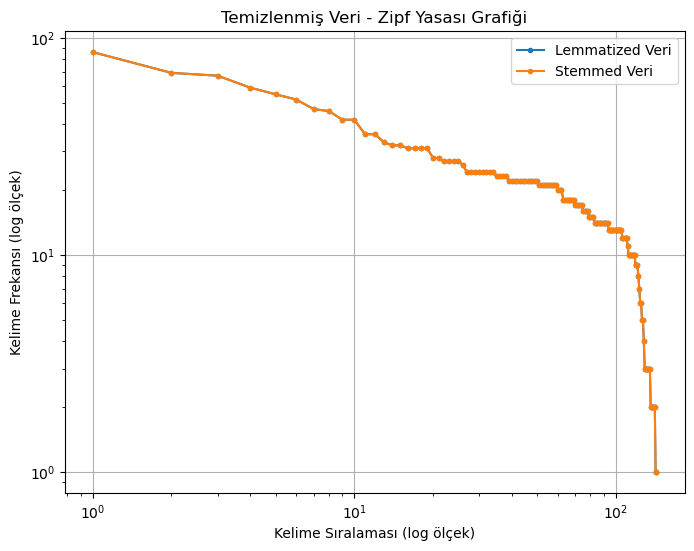

In [13]:
# Zipf Yasası Analizi (Temizlenmiş Veri)
lemmatized_tokens = [token for sent in tokenized_corpus_lemmatized for token in sent]
stemmed_tokens = [token for sent in tokenized_corpus_stemmed for token in sent]

lemmatized_freq = Counter(lemmatized_tokens)
stemmed_freq = Counter(stemmed_tokens)

lemmatized_freq_sorted = sorted(lemmatized_freq.values(), reverse=True)
stemmed_freq_sorted = sorted(stemmed_freq.values(), reverse=True)
ranks = range(1, max(len(lemmatized_freq_sorted), len(stemmed_freq_sorted)) + 1)

plt.figure(figsize=(8, 6))
plt.loglog(ranks[:len(lemmatized_freq_sorted)], lemmatized_freq_sorted, marker='.', label='Lemmatized Veri')
plt.loglog(ranks[:len(stemmed_freq_sorted)], stemmed_freq_sorted, marker='.', label='Stemmed Veri')
plt.xlabel('Kelime Sıralaması (log ölçek)')
plt.ylabel('Kelime Frekansı (log ölçek)')
plt.title('Temizlenmiş Veri - Zipf Yasası Grafiği')
plt.grid(True)
plt.legend()
plt.savefig('zipf_cleaned.png')
print("Temizlenmiş veri Zipf grafiği kaydedildi: zipf_cleaned.png")
plt.show()


In [14]:
# TF-IDF Vektörleştirme
lemmatized_texts = [' '.join(tokens) for tokens in tokenized_corpus_lemmatized]
stemmed_texts = [' '.join(tokens) for tokens in tokenized_corpus_stemmed]

In [54]:
# 2. Hafta: TF-IDF Vektörizasyon 
# [1] Ön işleme (zaten yapıldı, lemmatize verileri kullanacağım)

# [2-3] Lemmatize metinleri oluşturma ve ilk 3’ünü gösterme
lemmatized_texts = [' '.join(tokens) for tokens in tokenized_corpus_lemmatized]
print("\nİlk 3 lemmatized metin:")
print(lemmatized_texts[:3])


İlk 3 lemmatized metin:
['yaz sezonun şeftali tarlamız yapraklar kahverengileşm büzüşm', 'sulam artırılmasın rağme bitkiler düzelm olmadı ye takviyesi yapmalı mıyız', 'mısır tarlamız genç fideler çekiş kaybı yaşanması']


In [15]:
# Lemmatized için
vectorizer_lemmatized = TfidfVectorizer()
tfidf_matrix_lemmatized = vectorizer_lemmatized.fit_transform(lemmatized_texts)
feature_names_lemmatized = vectorizer_lemmatized.get_feature_names_out()
tfidf_df_lemmatized = pd.DataFrame(tfidf_matrix_lemmatized.toarray(), columns=feature_names_lemmatized)
tfidf_df_lemmatized.to_csv('tfidf_lemmatized.csv', index=False, encoding='utf-8')

In [16]:
# Stemmed için
vectorizer_stemmed = TfidfVectorizer()
tfidf_matrix_stemmed = vectorizer_stemmed.fit_transform(stemmed_texts)
feature_names_stemmed = vectorizer_stemmed.get_feature_names_out()
tfidf_df_stemmed = pd.DataFrame(tfidf_matrix_stemmed.toarray(), columns=feature_names_stemmed)
tfidf_df_stemmed.to_csv('tfidf_stemmed.csv', index=False, encoding='utf-8')

print("\nTF-IDF Dosyaları Kaydedildi:")
print("- tfidf_lemmatized.csv")
print("- tfidf_stemmed.csv")
print("\nLemmatized TF-IDF İlk 5 Satır:")
print(tfidf_df_lemmatized.head())
print("\nStemmed TF-IDF İlk 5 Satır:")
print(tfidf_df_stemmed.head())


TF-IDF Dosyaları Kaydedildi:
- tfidf_lemmatized.csv
- tfidf_stemmed.csv

Lemmatized TF-IDF İlk 5 Satır:
   acil    aktarm  aldığımız  analizi  arttı  artırılmasın  atlar  azalması  \
0   0.0  0.000000        0.0      0.0    0.0      0.000000    0.0       0.0   
1   0.0  0.000000        0.0      0.0    0.0      0.312483    0.0       0.0   
2   0.0  0.000000        0.0      0.0    0.0      0.000000    0.0       0.0   
3   0.0  0.487473        0.0      0.0    0.0      0.000000    0.0       0.0   
4   0.0  0.000000        0.0      0.0    0.0      0.000000    0.0       0.0   

   azot  açmalı  ...  yumuşam  zeyt  zeytinler     çekiş  çürüklüğü  çürümesi  \
0   0.0     0.0  ...      0.0   0.0        0.0  0.000000        0.0       0.0   
1   0.0     0.0  ...      0.0   0.0        0.0  0.000000        0.0       0.0   
2   0.0     0.0  ...      0.0   0.0        0.0  0.398635        0.0       0.0   
3   0.0     0.0  ...      0.0   0.0        0.0  0.000000        0.0       0.0   
4   0.0     0.0

In [42]:
# 3. Hafta: Word2Vec Model Eğitimi 
# [16] Word2Vec modelleri eğitme
# Ön işleme zaten yapıldı, tokenized_corpus_lemmatized ve tokenized_corpus_stemmed kullanacağım

# Word2Vec modeli eğitmek için parametreler
parameters = [
    {'model_type': 'cbow', 'window': 2, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 2, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 100},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 100},
    {'model_type': 'cbow', 'window': 2, 'vector_size': 300},
    {'model_type': 'cbow', 'window': 4, 'vector_size': 300},
    {'model_type': 'skipgram', 'window': 4, 'vector_size': 300}
]


In [43]:
# Fonksiyon ile Word2Vec modeli eğitme ve kaydetme
def train_and_save_model(corpus, params, model_name):
    model = Word2Vec(corpus, vector_size=params['vector_size'],
                     window=params['window'], min_count=1,
                     sg=1 if params['model_type'] == 'skipgram' else 0)
    model.save(f"{model_name}_{params['model_type']}_window{params['window']}_dim{params['vector_size']}.model")
    print(f"{model_name}_{params['model_type']}_window{params['window']}_dim{params['vector_size']}.model saved!")

In [44]:
from gensim.models import Word2Vec

In [45]:
# Lemmatize edilmiş corpus ile modelleri eğitme ve kaydetme
for param in parameters:
    train_and_save_model(tokenized_corpus_lemmatized, param, "lemmatized_model")
    # Stemlenmiş corpus ile modelleri eğitme ve kaydetme
for param in parameters:
    train_and_save_model(tokenized_corpus_stemmed, param, "stemmed_model")

lemmatized_model_cbow_window2_dim100.model saved!
lemmatized_model_skipgram_window2_dim100.model saved!
lemmatized_model_cbow_window4_dim100.model saved!
lemmatized_model_skipgram_window4_dim100.model saved!
lemmatized_model_cbow_window2_dim300.model saved!
lemmatized_model_cbow_window4_dim300.model saved!
lemmatized_model_skipgram_window4_dim300.model saved!
stemmed_model_cbow_window2_dim100.model saved!
stemmed_model_skipgram_window2_dim100.model saved!
stemmed_model_cbow_window4_dim100.model saved!
stemmed_model_skipgram_window4_dim100.model saved!
stemmed_model_cbow_window2_dim300.model saved!
stemmed_model_cbow_window4_dim300.model saved!
stemmed_model_skipgram_window4_dim300.model saved!


In [53]:
# [17] Üç model yükleme ve "sorun" kelimesi için en benzer 5 kelimeyi yazdırma
# Model dosyalarını yükleme
try:
    model_1 = Word2Vec.load("lemmatized_model_cbow_window2_dim100.model")
    model_2 = Word2Vec.load("stemmed_model_skipgram_window2_dim300.model")
    model_3 = Word2Vec.load("lemmatized_model_skipgram_window2_dim300.model")

    # 'sorun' kelimesi ile en benzer 3 kelimeyi ve skorlarını yazdırma
    def print_similar_words(model, model_name):
        try:
            similarity = model.wv.most_similar('tarlamız', topn=5)
            print(f"\n{model_name} Modeli - 'tarlamız' ile En Benzer 5 Kelime:")
            for word, score in similarity:
                print(f"Kelime: {word}, Benzerlik Skoru: {score:.4f}")
        except KeyError:
            print(f"\n{model_name} Modeli - 'tarlamız' kelimesi modelde bulunamadı.")

    # 3 model için benzer kelimeleri yazdırma
    print_similar_words(model_1, "Lemmatized CBOW Window 2 Dim 100")
    print_similar_words(model_2, "Stemmed Skipgram Window 2 Dim 300")
    print_similar_words(model_3, "Lemmatized Skipgram Window 2 Dim 300")
except FileNotFoundError:
    print("\nModellerden biri bulunamadı. Önce modelleri eğitip kaydedin.")



Lemmatized CBOW Window 2 Dim 100 Modeli - 'tarlamız' ile En Benzer 5 Kelime:
Kelime: müdahal, Benzerlik Skoru: 0.4801
Kelime: kök, Benzerlik Skoru: 0.4612
Kelime: sezonun, Benzerlik Skoru: 0.4008
Kelime: aşırı, Benzerlik Skoru: 0.3893
Kelime: bıçaklar, Benzerlik Skoru: 0.3864

Stemmed Skipgram Window 2 Dim 300 Modeli - 'tarlamız' ile En Benzer 5 Kelime:
Kelime: genç, Benzerlik Skoru: 0.7371
Kelime: aşırı, Benzerlik Skoru: 0.7232
Kelime: kök, Benzerlik Skoru: 0.6888
Kelime: sık, Benzerlik Skoru: 0.6840
Kelime: kuruma, Benzerlik Skoru: 0.6803

Lemmatized Skipgram Window 2 Dim 300 Modeli - 'tarlamız' ile En Benzer 5 Kelime:
Kelime: genç, Benzerlik Skoru: 0.7371
Kelime: aşırı, Benzerlik Skoru: 0.7232
Kelime: kök, Benzerlik Skoru: 0.6888
Kelime: sık, Benzerlik Skoru: 0.6840
Kelime: kuruma, Benzerlik Skoru: 0.6803


In [52]:
model = Word2Vec.load("lemmatized_model_cbow_window2_dim100.model")

# En sık kullanılan 20 kelime
print("Modeldeki En Sık 20 Kelime:")
for word in model.wv.index_to_key[:20]:
    print(word)


Modeldeki En Sık 20 Kelime:
olabilir
genç
tarlamız
sulam
birikimi
drenaj
aşırı
yaz
kök
fideler
söz
konusu
su
toprakt
eksikliği
gerekli
programını
gübrelem
mıyız
sık
